In [84]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score


In [2]:
# Paths to the dataset
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'


In [3]:
# Image size for ResNet50
IMG_SIZE = 224
BATCH_SIZE = 32

In [4]:
# Preprocessing function from ResNet50
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [5]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Since it's a binary classification problem
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [56]:
# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


In [57]:
# Freeze base ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

In [69]:
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

In [59]:
# Model
model = Model(inputs=base_model.input, outputs=predictions)

In [60]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [39]:
# Reduce learning rate when a metric has stopped improving
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)


In [61]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=10,
 #callbacks=[reduce_lr]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 574ms/step - accuracy: 0.7406 - loss: 0.5957 - val_accuracy: 0.5625 - val_loss: 0.8863
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.8863
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 558ms/step - accuracy: 0.7744 - loss: 0.4670 - val_accuracy: 0.6250 - val_loss: 0.6825
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6825
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 568ms/step - accuracy: 0.7981 - loss: 0.4328 - val_accuracy: 0.5625 - val_loss: 0.8887
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.8887
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 563ms/step - accuracy: 0.8007 - loss: 0.4163 - val_accuracy: 0.6250 - val_loss: 0.7388
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0

In [62]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test accuracy: {test_acc}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step - accuracy: 0.7676 - loss: 0.5239
Test accuracy: 0.8042762875556946


In [63]:
# Unfreeze and fine-tune some ResNet50 layers
for layer in base_model.layers[-10:]:
    layer.trainable = True


In [70]:
# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 6,564,865 (25.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [73]:
# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    #callbacks=[reduce_lr]
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 567ms/step - accuracy: 0.8897 - loss: 0.2356 - val_accuracy: 0.6250 - val_loss: 1.0304
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 567ms/step - accuracy: 0.8990 - loss: 0.2331 - val_accuracy: 0.6250 - val_loss: 0.9265
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 561ms/step - accuracy: 0.8931 - loss: 0.2315 - val_accuracy: 0.6250 - val_loss: 0.9163
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 561ms/step - accuracy: 0.8978 - loss: 0.2386 - val_accuracy: 0.6250 - val_loss: 0.8639
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 564ms/step - accuracy: 0.9014 - loss: 0.2286 - val_accuracy: 0.6250 - val_loss: 0.9752


In [74]:
# Final evaluation on test data
final_test_loss, final_test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Final test accuracy: {final_test_acc}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.7721 - loss: 0.6892
Final test accuracy: 0.8289473652839661


In [80]:
# Get the true labels
y_true = test_generator.classes

# Predict on test data using the exact number of steps to match y_true
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convert probabilities to binary class (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step


In [81]:
# Now y_pred_classes should match y_true
print(f"True labels shape: {len(y_true)}")
print(f"Predicted labels shape: {len(y_pred_classes)}")

True labels shape: 624
Predicted labels shape: 624


In [82]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = ['Normal', 'Pneumonia']

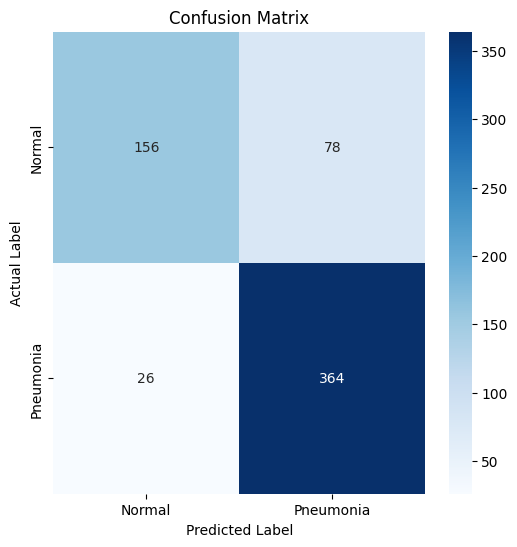

In [85]:
# Plot Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [86]:
# Print classification metrics
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8235
Recall: 0.9333
F1 Score: 0.8750


In [87]:
# Optional: detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
               precision    recall  f1-score   support

      Normal       0.86      0.67      0.75       234
   Pneumonia       0.82      0.93      0.87       390

    accuracy                           0.83       624
   macro avg       0.84      0.80      0.81       624
weighted avg       0.84      0.83      0.83       624



In [105]:
# Define the model save path
model_save_path = '/kaggle/working/x-ray.h5'  # Change the filename as needed

# Save the model
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/x-ray.h5


In [130]:
# Number of images to fetch
num_batches = 20  # Adjust as needed
images = []
labels = []

for _ in range(num_batches):
    x_batch, y_batch = next(test_generator)
    images.extend(x_batch)  # Add batch images to the list
    labels.extend(y_batch)   # Add batch labels to the list

# Convert lists to numpy arrays if needed
images = np.array(images)
labels = np.array(labels)

print(f"Fetched {len(images)} images and their labels.")

Fetched 96 images and their labels.


/tmp/ipykernel_36/870150001.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_names[int(labels[i+30])]}\nPred: {class_names[int(y_pred_classes[i+30])]}")


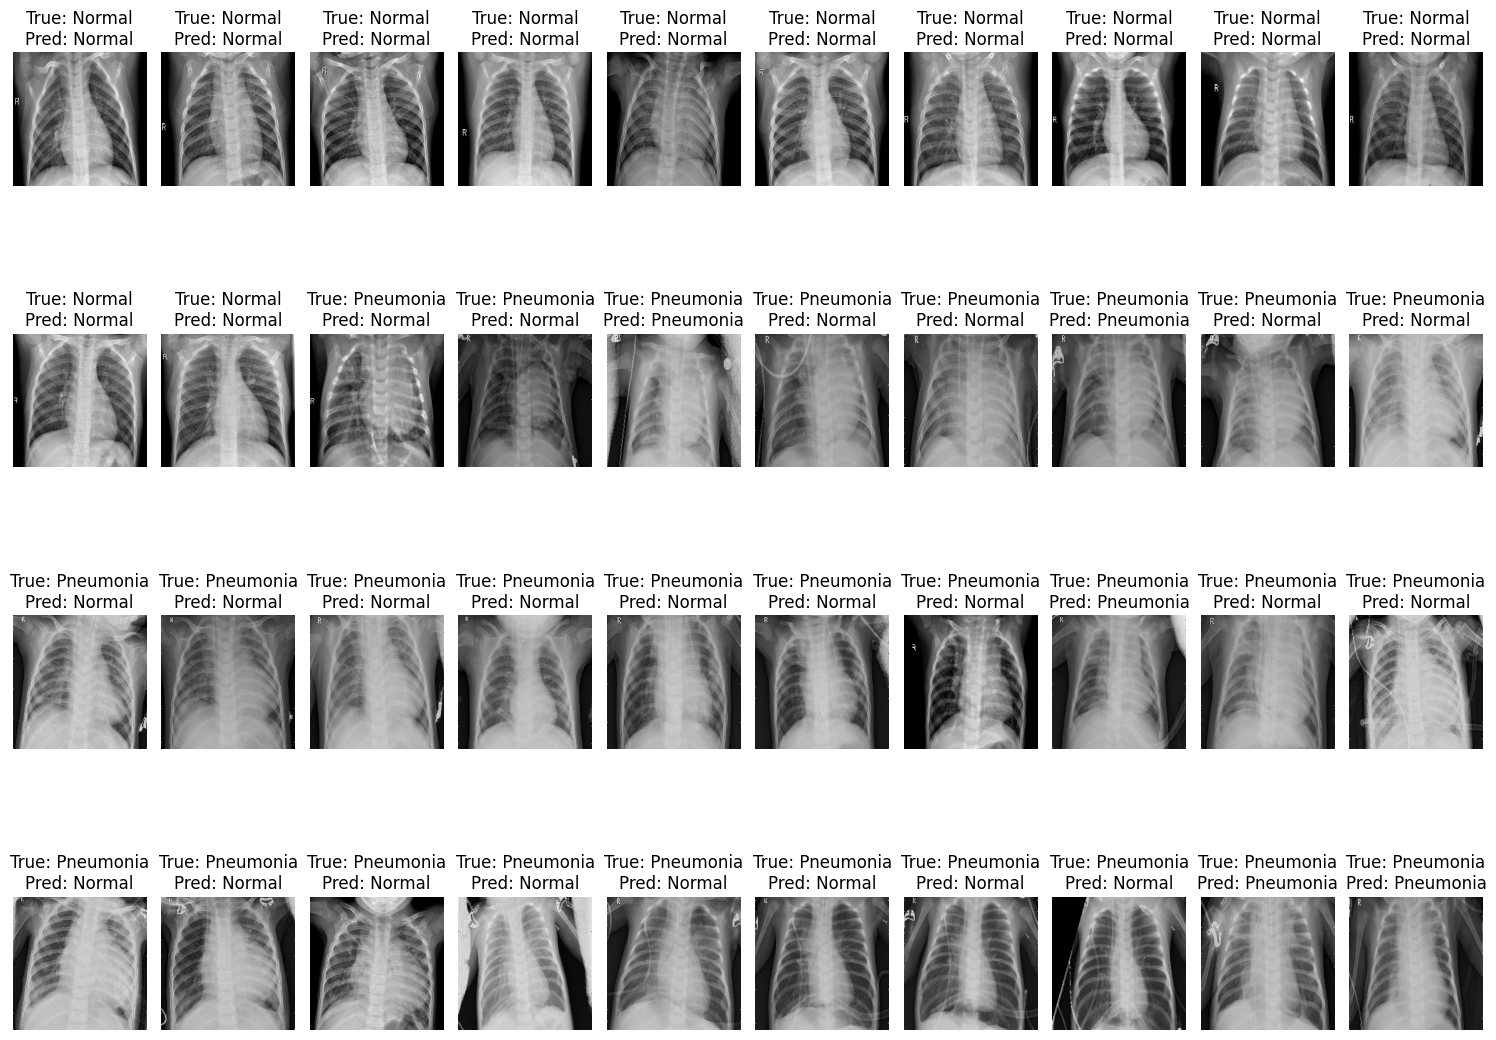

In [137]:
# Number of images to display
num_images = 40  # Change this to display more images if needed

# Calculate the number of rows based on 5 images per row
num_cols = 10
num_rows = (num_images // num_cols) + int(num_images % num_cols != 0)

plt.figure(figsize=(15, 3 * num_rows))  # Adjust figure size based on number of rows

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(images[i+30], cmap='gray')
    plt.title(f"True: {class_names[int(labels[i+30])]}\nPred: {class_names[int(y_pred_classes[i+30])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()